In [16]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

from segpy.reader import create_reader
from scipy import interpolate

np.set_printoptions(linewidth=120)
plt.rcParams['figure.figsize'] = (19, 13)

Define two helper functions

In [2]:
def read_shots(segy_file, traces_per_gather):
    # read in SEGY file
    shots = []
    shot_id = []
    shot_id_unique = []
    try:
        with open(segy_file, 'rb') as in_file:
            segy_reader = create_reader(in_file)
            for i in segy_reader.trace_indexes():
                trace = segy_reader.trace_samples(i)
                header = segy_reader.trace_header(i)
                shots.append(list(trace))
                shot_id.append(header.field_record_num)

                # keep track of unique shot IDs, assume that shots are sorted contiguously
                if header.field_record_num not in shot_id_unique:
                    shot_id_unique.append(header.field_record_num)
    except EnvironmentError:
        print('Error reading file')
        return None

    shot_id = np.asarray(shot_id, dtype=int)
    shot_id_unique = np.asarray(shot_id_unique, dtype=int)
    shots = np.asarray(shots, dtype=float)
    num_samples = len(shots[0])

    # prepare output array
    shots_np = np.zeros((len(shot_id_unique), traces_per_gather, num_samples), dtype=float)
    shot_counter = 0
    for shot in shot_id_unique:
        curr_shot = shots[shot_id == shot]
        num_traces = len(curr_shot)

        if num_traces != traces_per_gather:
            # need to resize
            resized_shot = np.zeros((num_samples, traces_per_gather), dtype=float)

            i = 0
            abscissa = np.linspace(0, num_traces - 1, num=num_traces, endpoint=True)
            interp_abscissa = np.linspace(0, num_traces - 1, num=traces_per_gather, endpoint=True)
            for time_slice in np.transpose(curr_shot):
                # define cubic interpolator
                cubic_interp = interpolate.interp1d(abscissa, time_slice, kind='cubic')
                resized_shot[i] = cubic_interp(interp_abscissa)
                i += 1

            shots_np[shot_counter, :, :] = np.transpose(resized_shot)
        else:  # no need to resize
            shots_np[shot_counter, :, :] = curr_shot

        shot_counter += 1

    return shots_np, shot_id_unique


def clip_traces_vgg(shots, clip_value):
    # clips, re-scale and re-mean traces to make it compatible with VGGNet
    # note that values are still single precision floating point numbers (float32), even though it has the same range as uint8
    clip_value = np.abs(clip_value)

    output = np.clip(shots, a_min=-clip_value, a_max=clip_value)

    # scale to twice of clip value, assuming data has mean of zero
    output = (output + clip_value) / (2.0 * clip_value)

    return 255 * output

# Step 0a Read in SEGY files 
Read in SEGY files of shots before and after AAA.

**WARNING!** This can take hours

In [3]:
# read in Rev XII SEGY files
traces_per_shot = 621
path = '//hofs644.houston-us0380.slb.com/ho0338/eh17/CNN_QC_Assistant_ee71/seismic_other/101_Migration_Preparation_T/'
shots_before, shot_id = read_shots(path + '101T02_Shots_SEGY_AAA_Input', traces_per_shot)
path = '//hofs515.houston-us0380.slb.com/ho0327/eh17/CNN_QC_Assistant_ee71/seismic_other/101_Migration_Preparation_T/'
shots_after, _ = read_shots(path + '101T02_Shots_SEGY_AAA_Output', traces_per_shot)

# Step 0b Feature Engineering
Convert shot gathers before and after AAA into a color image.

Reason: We would like to use a ConvNet trained on color images of natural objects. The ConvNet is called VGG16

In [4]:
# clip seismic amplitudes
clip_value = 2
diff_scalar = 12
diff = clip_traces_vgg(diff_scalar*(shots_before - shots_after), clip_value)
before = clip_traces_vgg(shots_before, clip_value)
after = clip_traces_vgg(shots_after, clip_value)

Represent seismic gathers as color images using the following scheme:

(R, G, B) = (After, 12 X Diff, 12 X Diff)

This embedding is not unique. 

Finally merge all the gathers together into one big Numpy array called ```X_raw_all ```

In [5]:
# stack shots together to form RGB images
X_raw_all = np.stack((after, diff, diff), axis=-1).astype(np.float32)
print(X_raw_all.shape)

(1042, 621, 512, 3)


# Step 0c Data QC
Check to make sure the training set features look reasonable

Display two random "color" shots

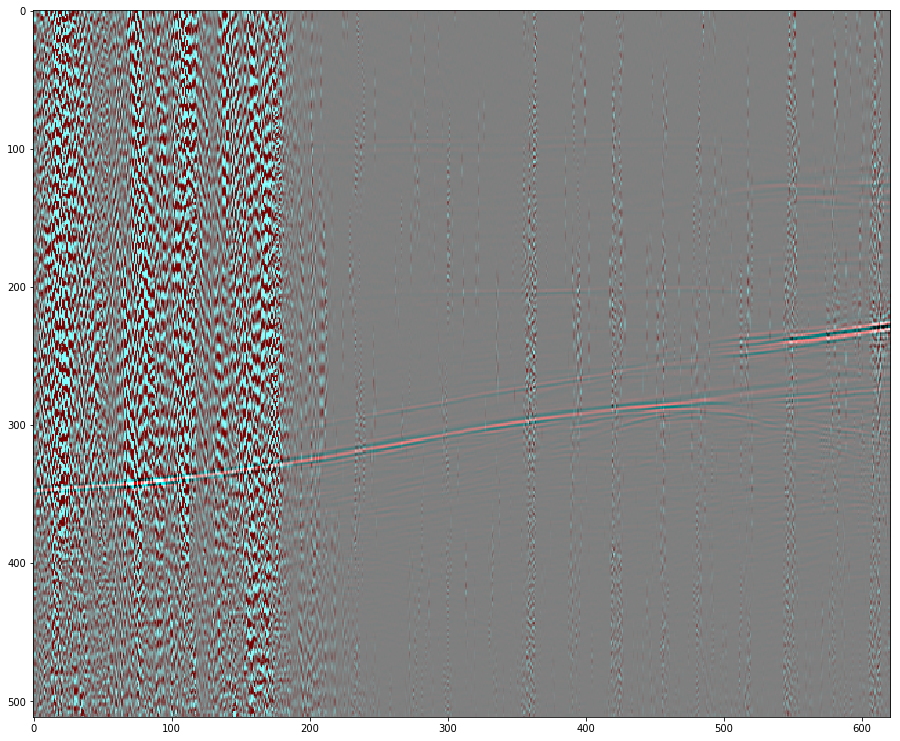

In [17]:
shot_num = 48
plt.imshow(np.transpose(X_raw_all[shot_num], axes=(1, 0, 2)).astype(np.uint8), origin='upper');

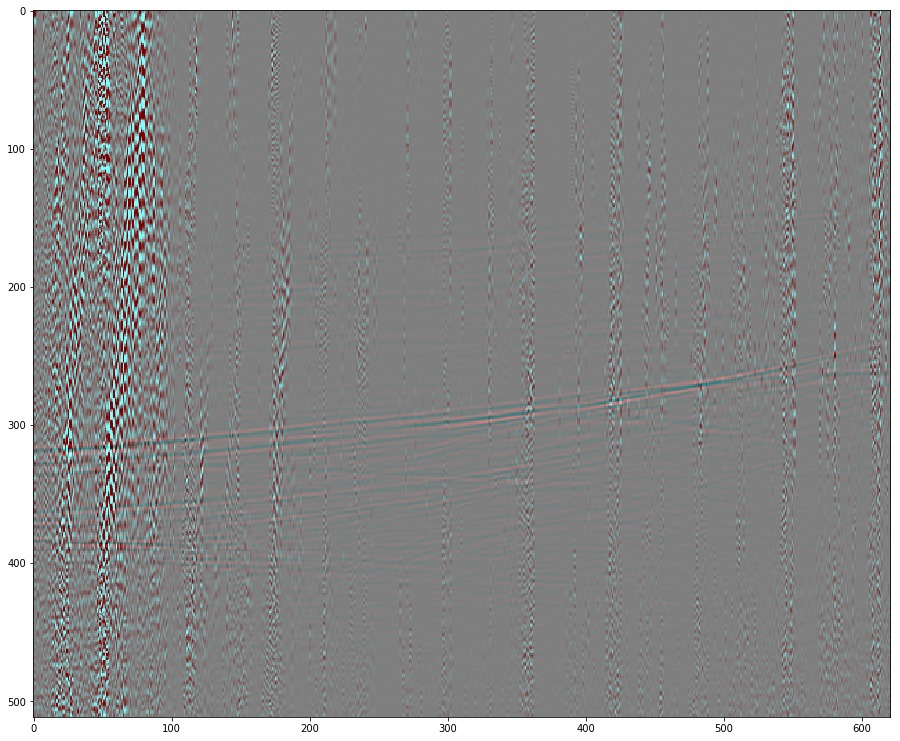

In [18]:
shot_num = 222
plt.imshow(np.transpose(X_raw_all[shot_num], axes=(1, 0, 2)).astype(np.uint8), origin='upper');

# Step 0d Prepare Binary Classification Labels
This is a supervised problem so each shot gather (or more accurately SHOT_NUM) has a PASS/FAIL label from Lennin Escobar. Below we read in Lennin's labels for each shot gather

Our convention is 0 = FAIL and 1 = PASS

In [21]:
# read in classification labels
bad_shots = {}
path = '//hona01a.houston-us0380.slb.com/ud/eh17/CNN_QC_Assistant_ee71/text_files/101_Migration_Preparation_T/'
with open(path + 'List_Ident_Num_DL_RevXII_Exp.txt', 'r') as in_file:
    in_file.readline()
    in_file.readline()
    for line in in_file:
        bad_shots[int(line)] = 1

# convert to one-hot-vectors, 0 = FAIL, 1 = PASS
Y_all = np.zeros(len(shot_id)).astype(np.int)
for i in range(len(shot_id)):
    if shot_id[i] not in bad_shots:
        Y_all[i] = 1

print(Y_all.shape)

(1042,)


In [22]:
# write raw images and shot ID list to disk
path = 'D:/Projects/eh17_NAM/Machine_Learning/AAA_QC/numpy_data/'
np.savez_compressed(path + 'RevXII_RawData.npz', X_raw_all=X_raw_all, shot_id=shot_id, Y_all=Y_all)

We write the Numpy array to disk so we don't have to read the SEGYs every time. It's much faster to read the Numpy arrays directly.